<a href="https://colab.research.google.com/github/skmisht/CNN/blob/kfold_cnn_pytorch/CNN_PyTorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Melanoma-detection-using-Deep Convolution Neural Network-PyTorch 

In [1]:
import os
import shutil
import pandas as pd 
import matplotlib.pyplot as plt 
import numpy as np
import matplotlib.image as img
%matplotlib inline
# torch
import torch
print("Current Torch version: ", torch.__version__)
# to install if there is no latest version of torch
# !pip install -q torch==1.0.0 
import torchvision
import torch.nn.functional as F
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
# test if the notebook is running on GPU
import tensorflow as tf
tf.test.gpu_device_name()

Current Torch version:  1.8.0+cu101


'/device:GPU:0'

# ISIC 2017 Dataset

In [2]:
# accessing data files from google drive
from google.colab import drive
drive.mount('/content/drive')

# list of files in Melanoma folder
base_dir = '/content/drive/My Drive/Melanoma'
for file in os.listdir(base_dir):
  if os.path.isdir(os.path.join(base_dir, file)) or os.path.isfile(os.path.join(base_dir, file)):
    print(file)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
ISIC-2017_Test_v2_Data_metadata.csv
ISIC-2017_Training_Data_metadata.csv
ISIC-2017_Validation_Data_metadata.csv
ISIC-2017_Validation_Part3_GroundTruth.csv
ISIC-2017_Training_Part3_GroundTruth.csv
ISIC-2017_Test_v2_Part3_GroundTruth.csv
ISIC-2017_Training
ISIC-2017_Test
ISIC-2017_Validation


In [3]:
# reading the melanoma labels - groundtruth csv's for train, validation, and test
train_labels = pd.read_csv('/content/drive/MyDrive/Melanoma/ISIC-2017_Training_Part3_GroundTruth.csv',
                           delimiter=',',
                           usecols=['image_id', 'melanoma'])

test_labels = pd.read_csv('/content/drive/MyDrive/Melanoma/ISIC-2017_Test_v2_Part3_GroundTruth.csv', 
                          delimiter=',', 
                          usecols=['image_id', 'melanoma'])

valid_labels = pd.read_csv('/content/drive/MyDrive/Melanoma/ISIC-2017_Validation_Part3_GroundTruth.csv',
                           delimiter=',', 
                           usecols=['image_id', 'melanoma'])

# melanoma images
train_images = r'/content/drive/MyDrive/Melanoma/ISIC-2017_Training/ISIC-2017_Training_Data'
validation_images = r'/content/drive/MyDrive/Melanoma/ISIC-2017_Validation/ISIC-2017_Validation_Data' 
test_images = r'/content/drive/MyDrive/Melanoma/ISIC-2017_Test/ISIC-2017_Test_v2_Data'

# total images in each dir - train, test, validation
print("Training Images: ", len(os.listdir(train_images)))
print("Test Images: ", len(os.listdir(test_images)))
print("Validation Images: ", len(os.listdir(validation_images)))

Training Images:  4000
Test Images:  1200
Validation Images:  300


Check if there is any overlap between Train, Test, and Validation images

In [8]:
train_validation = [x for x in validation_images if x in train_images]
train_test = [x for x in test_images if x in train_images]
validation_test =  [x for x in test_images if x in validation_images]
# if len > 0 means overlap
if (len(train_validation) > 0 or len(train_test) > 0 or len(validation) > 0):
  print("Training-Validation:",len(train_validation), "Training-Test:",len(train_test), "Validation-Test:",len(validation_test))
else:
  print("No, there is no overlap!")

Training-Validation: 76 Training-Test: 67 Validation-Test: 65


Display sample images from Training, Test, and Validation

Train Images:
 


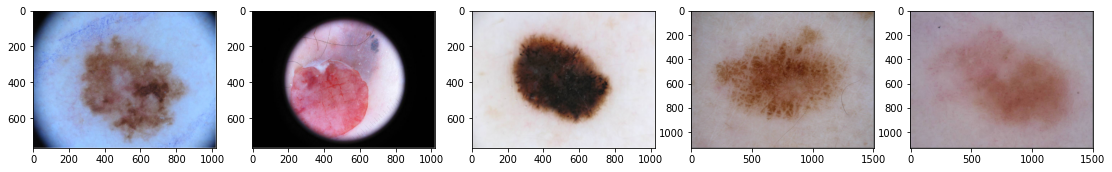

Test Images:
 


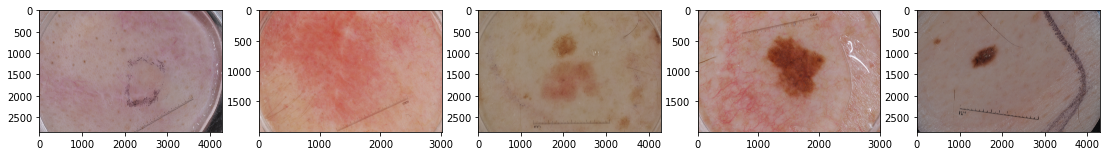

Validation Images:
 


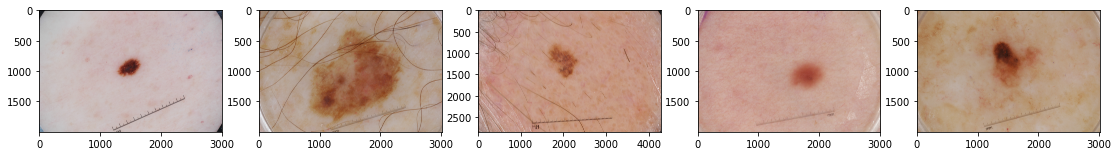

In [4]:
def display_images(data, img_path, width =10 , height =10):
    fig,ax = plt.subplots(1,5,figsize = (19,5))
    for i, idx in enumerate(data[data['melanoma'] == 1]['image_id'][:5]):
      path = os.path.join(img_path, idx) +'.jpg'
      ax[i].imshow(img.imread(path))
    # display images 
    plt.show()

# calling function on train, test, and valdiation sets
print("Train Images:\n ")
display_images(train_labels, train_images, 10, 10) # , width=10, height=10)
print("Test Images:\n ")
display_images(test_labels, test_images, 10, 10)
print("Validation Images:\n ")
display_images(valid_labels, validation_images, 10, 10) 

# PyTorch - Custom Dataset & DataLoader

In [ ]:
class ISICDataset(Dataset):
  # initialising the variables
  def __init__(self, data, image_path, transform=None): 
    super().__init__()
    self.data = data.values
    self.image_path = image_path
    self.transform = transform

  # method to get the length of dataset
  def __len__(self):
    return len(self.data)
    
  # accessing each item in the dataset
  def __getitem__(self, index):
    images, label = self.data[index]
    img_path = os.path.join(self.image_path, images + '.jpg')
    image = img.imread(img_path)
    # if transform is None
    if self.transform is not None:
      image = self.transform(image)

    return image, label

# Defining Hyperparameters
  - number of epochs
  - number of class
  - Image Szie
  - batch size
  - learning rate

In [ ]:
# Hyperparameter values
num_epochs = 10
num_classes = 2
img_size = 150
batch_size = 20
validation_batch_size = 20
learning_rate = 0.001

# Image Data Augmentation
  - Training data
  - Test Data
  - Validation Data

More information [PyTorch.org](https://pytorch.org/docs/0.2.0/_modules/torchvision/transforms.html#ToTensor)


In [ ]:
# Train
train_transform = transforms.Compose([transforms.ToPILImage(),
                                      transforms.Resize((img_size, img_size)),
                                      transforms.RandomHorizontalFlip(p=0.5),
                                      transforms.RandomVerticalFlip(p=0.5),
                                      transforms.RandomRotation(20),
                                      transforms.ToTensor(),
                                      transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                           std=[0.229, 0.224, 0.225])])

# Test
test_transform = transforms.Compose([transforms.ToPILImage(),
                                     transforms.Resize((img_size, img_size)),
                                     transforms.RandomHorizontalFlip(p=0.5),
                                     transforms.RandomVerticalFlip(p=0.5),
                                     transforms.RandomRotation(20),
                                     transforms.ToTensor(),
                                     transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                          std=[0.229, 0.224, 0.225])])
# Validation
valid_transform = transforms.Compose([transforms.ToPILImage(),
                                     transforms.Resize((img_size, img_size)),
                                     transforms.RandomHorizontalFlip(p=0.5),
                                     transforms.RandomVerticalFlip(p=0.5),
                                     transforms.RandomRotation(20),
                                     transforms.ToTensor(),
                                     transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                          std=[0.229, 0.224, 0.225])])

In [ ]:
# CPU or GPU
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

# Datsets
  - Train - fitting parameters to a classifier
  - Validadtion - to tune the hyperparameters such as learning rate, and epochs
  - Test - final evaluation of model

In [ ]:
# Instantiating Custom Datasets class - ISICDataset
train_data = ISICDataset(train_labels, train_images, train_transform )
valid_data = ISICDataset(valid_labels, validation_images, valid_transform )
test_data = ISICDataset(test_labels, test_images, test_transform )

# Dataloader - to combines a dataset and a sampler
train_loader = DataLoader(dataset = train_data, batch_size = batch_size, shuffle=True, num_workers=0)
valid_loader = DataLoader(dataset = valid_data, batch_size = validation_batch_size, shuffle=False, num_workers=0)
test_loader = DataLoader(dataset = test_data, batch_size = validation_batch_size, shuffle=False, num_workers=0)

# Standardise Images

# -----------[train_loader] ------------#
Training Images:
torch.Size([3, 150, 150])

# ------------[valid_loader] -----------#
Validation Images:
torch.Size([3, 150, 150])

# -----------[test_loader] -----------#
Test Images:
torch.Size([3, 150, 150])


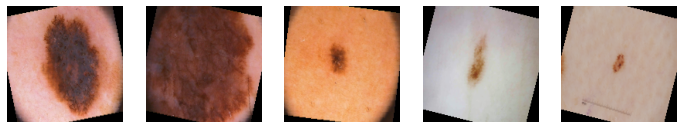

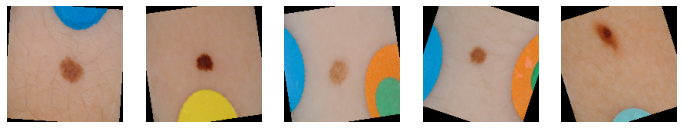

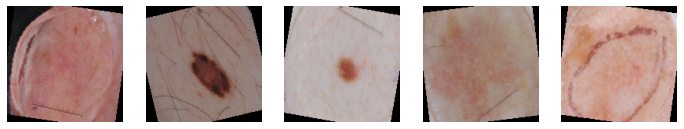

In [ ]:
# Function to stadardised the image using mean and std - Training set
def ImageShow(image, ax=None, title=None, normalize=True):
    if ax is None:
        fig, ax = plt.subplots()
    image = image.numpy().transpose((1, 2, 0))

    # image normalisation condition
    if normalize:
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        image = std * image + mean
        image = np.clip(image, 0, 1)

    ax.imshow(image)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.tick_params(axis='both', length=0)
    ax.set_xticklabels('')
    ax.set_yticklabels('')

    return ax 


print('# -----------[train_loader] ------------#')
training_images, training_labels = next(iter(train_loader))
fig, axes = plt.subplots(figsize=(12, 12), ncols=5)
print('Training Images:')

# iterate over the training images
for i in range(5):
  ax1 = axes[i]
  ImageShow(training_images[i], ax=ax1, normalize=True)

# display training images - torch size
print(training_images[0].size())

print() # blank line

print('# ------------[valid_loader] -----------#')
validation_images, validation_labels = next(iter(valid_loader))
fig, axes = plt.subplots(figsize=(12, 12), ncols=5)
print('Validation Images:')

# iterate over the training images
for i in range(5):
  ax1 = axes[i]
  ImageShow(validation_images[i], ax=ax1, normalize=True)

# display training images - torch size
print(validation_images[0].size())

print() # blank line

print('# -----------[test_loader] -----------#')
testing_images, testing_labels = next(iter(test_loader))
fig, axes = plt.subplots(figsize=(12, 12), ncols=5)
print('Test Images:')

# iterate over the training images
for i in range(5):
  ax1 = axes[i]
  ImageShow(testing_images[i], ax=ax1, normalize=True)

# display the test images
print(testing_images[0].size())

# Designing Convolution Neural Network (CNN)
Parameters of __init__:
  - in_channels = 3 -->> Indicates the color channel of the input image.
  - out_channels = 3 -->> number of filter to be used for convolution layer.
  - kernal_size = 3 -->> size of the filter window (2D matrix) to apply to the input images.
  - nn.Dropout2d() -->> preventing Overfitting and only used during training the model, and always shuts down when model goes into the evaluation. 
  nn.Linear() -->> applies the linear transformation to the input data. 

Parrameter of forward():
  - max_pool2d() -->> selecting maximum element from the feature.
  - F.relu() -->>
  F.Dropout() -->> 

For more info: [PyTorch](https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html)

In [ ]:
import torch.nn as nn
# define the CNN model
class ISIC_CNN(nn.Module):
  # initialiser
  def __init__(self):
    super(ISIC_CNN, self).__init__()
    # 1st convolution
    self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3)
    self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
    # 2nd convolution
    self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3)
    self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3)
    self.conv4 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3)

    # The output of the last max pool layer - 128*128*7
    self.fc1 = nn.Linear(128*7*7, 512)
    self.fc2 = nn.Linear(512, 2) 
  # forward parameter
  def forward(self, x):
    x = self.pool(F.relu(self.conv1(x)))
    x = self.pool(F.relu(self.conv2(x)))
    x = self.pool(F.relu(self.conv3(x)))
    x = self.pool(F.relu(self.conv4(x)))
    # flatten layer
    x = x.view(-1, 128*7*7)
    x = F.relu(self.fc1(x))
    x = self.fc2(x)
    return x

# Instantiating the class
model = ISIC_CNN()
print(model)

ISIC_CNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (conv4): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=6272, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=2, bias=True)
)


# Define a Loss function and Optimzer

In [ ]:
import torch.optim as optim
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Device: ", device)
# model.to(device)
model = ISIC_CNN().to(device)

criterion = nn.CrossEntropyLoss()
# criterion = nn.BCEWithLogitsLoss()
# optimizer = optim.Adam(model.parameters(), lr=learning_rate)
optimizer = optim.RMSprop(model.parameters(), lr = learning_rate)
model

Device:  cuda:0


ISIC_CNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (conv4): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=6272, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=2, bias=True)
)

# Train the network
  - Loopping over the data iterator
  - feeding the inputs to the network and optimzer

In [ ]:
%%time
# record the losses
train_losses = []
valid_losses = []

# loop over the dataset multiple times
for epoch in range(num_epochs):
  # record the train and validation losses
  train_loss = 0.0
  valid_loss = 0.0

  # training the model
  model.train()
  for data, target in train_loader:
    # move tensor to GPU
    data = data.to(device)
    target = target.to(device)
    # zero the parameter gradients
    optimizer.zero_grad()
    # forward pass: compute-predicted-output by passing input to the model
    output = model(data)
    # calculate the batch loss
    # loss = criterion(output, target) 
    loss = criterion(output, target.long())
    # backward-pass: compute-gradient of the loss
    loss.backward()
    # perform a single optimisation step
    optimizer.step()
    # uopdate the training loss
    train_loss += loss.item() * data.size(0)

  # validate the model
  model.eval()
  for data, target in valid_loader:
    # move tensor to GPU
    data = data.to(device)
    target = target.to(device)
    # forward pass
    output = model(data)
    # calculate the batch loss
    # loss = criterion(output, target)
    loss = criterion(output, target.long())
    # update validation loss
    valid_loss += loss.item() * data.size(0)


  # calculate the average loss
  train_loss = train_loss / len(train_loader.sampler)
  valid_loss = valid_loss / len(valid_loader.sampler)
  train_losses.append(train_loss)
  valid_losses.append(valid_loss)

  # display training and validation loss
  print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(epoch, train_loss, valid_loss))

Epoch: 0 	Training Loss: 1.885777 	Validation Loss: 0.571526
Epoch: 1 	Training Loss: 0.483691 	Validation Loss: 0.460747
Epoch: 2 	Training Loss: 0.475432 	Validation Loss: 0.448445
Epoch: 3 	Training Loss: 0.472638 	Validation Loss: 0.481692
Epoch: 4 	Training Loss: 0.472530 	Validation Loss: 0.467507
Epoch: 5 	Training Loss: 0.466785 	Validation Loss: 0.457495
Epoch: 6 	Training Loss: 0.474613 	Validation Loss: 0.438041
Epoch: 7 	Training Loss: 0.465326 	Validation Loss: 0.440320
Epoch: 8 	Training Loss: 0.480492 	Validation Loss: 0.469197
Epoch: 9 	Training Loss: 0.471702 	Validation Loss: 0.459265
CPU times: user 1h 2min 27s, sys: 1min 47s, total: 1h 4min 14s
Wall time: 1h 37min 20s


# Save & load model 
[PyTorch Link](https://pytorch.org/tutorials/beginner/saving_loading_models.html)


In [ ]:
# Saving the model
torch.save(model.state_dict(), 'melanoma_model.ckpt')
checkpoint_path = "melanoma_model.ckpt"

# Evaluation

In [ ]:
# loading model from ckpt file
model.load_state_dict(torch.load(checkpoint_path))
# model evaluation - accuracy score
model.eval()
with torch.no_grad():
  correct = 0
  total = 0
  # loop through image and labels 
  for images, labels in valid_loader:
    images, labels = images.to(device), labels.to(device)
    outputs = model(images)
    _, predicted = torch.max(outputs.data, 1)
    # increment the total
    total += labels.size(0)
    # increment the corerect
    correct += (predicted == labels).sum().item()

  # display results
  print('Accuracy score for the model: {} %'.format(100 * correct / total))

Accuracy score for the model: 80.0 %


In [ ]:
# # Confusion Matrix
# from sklearn.metrics import confusion_matrix
# # # laoding from saved ckpt file
# # model.load_state_dict(torch.load(checkpoint_path))
# model.eval()
# with torch.no_grad():
#   correct = 0
#   total = 0
#   predlist=torch.zeros(0,dtype=torch.long, device='cpu')
#   lbllist=torch.zeros(0,dtype=torch.long, device='cpu')
#   # loop through image and labels 
#   for images, labels in valid_loader:
#     images, labels = images.to(device), labels.to(device)
#     outputs = model(images)
#     _, predicted = torch.max(outputs.data, 1)
#     # increment the total
#     total += labels.size(0)
#     # increment the corerect
#     correct += (predicted == labels).sum().item()
#     predlist=torch.cat([predlist,predicted.view(-1).cpu()])
#     lbllist=torch.cat([lbllist,labels.view(-1).cpu()])
#   # display results
#   print('Accuracy score for the model: {} %'.format(100 * correct / total))
#   conf_mat=confusion_matrix(lbllist.numpy(), predlist.numpy())
#   print(f"Confusion Matrix:\n {conf_mat}")

Accuracy score for the model: 80.0 %
Confusion Matrix:
 [[120   0]
 [ 30   0]]


# Plotting Training Vs Validation losses

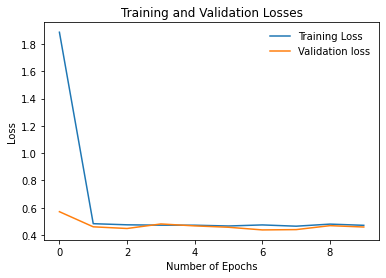

In [ ]:
# Plotting Training and validation loss
plt.plot(train_losses, label='Training Loss')
plt.plot(valid_losses, label='Validation loss')
plt.title('Training and Validation Losses')
plt.xlabel('Number of Epochs')
plt.ylabel('Loss')
plt.legend(frameon=False)

# Model validation - Performance metrics

# Clean up 
- to terminate the kernal and free memory resources

In [ ]:
import os, signal
os.kill(os.getpid(), signal.SIGKILL)